In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import copy


## Read true race data

In [2]:
db = pd.read_csv("../../RegressionModelForRacingStrategy/finalDataset.csv")
driver_info = pd.read_csv("../../RacingStrategy/f1db_csv/drivers.csv")
complete = pd.read_csv("../../RegressionModelForRacingStrategy/completeDataset.csv")

In [3]:
complete.describe()

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,stop,constructorId,...,safety(%),safety,rainy,cumulative,one-step_gap,2-sec-gap,1-sec-gap,0-5-sec-gap,battle,nextLap
count,131527.000000,131527.000000,131527.000000,131527.000000,1.315270e+05,131527.000000,131527.000000,131527.000000,131527.000000,131527.000000,...,131527.000000,131527.000000,131527.000000,1.315270e+05,1.315270e+05,131527.000000,131527.000000,131527.000000,131527.000000,1.315270e+05
mean,968.046211,558.576300,30.092300,9.697142,9.765637e+04,2016.561535,10.631779,22.692709,1.141340,53.685973,...,103.325028,0.001384,0.086401,2.949210e+06,7.118044e+03,0.177021,0.129319,0.072183,0.171949,9.549073e+04
std,37.882241,377.869267,18.252277,5.440653,6.276155e+04,1.709170,5.811309,23.142825,1.023798,78.639183,...,59.576059,0.037173,0.280956,1.765880e+06,2.223107e+04,0.381688,0.335554,0.258791,0.377338,6.235706e+04
min,900.000000,1.000000,1.000000,1.000000,6.695700e+04,2014.000000,1.000000,1.000000,0.000000,1.000000,...,81.000000,0.000000,0.000000,7.150600e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,938.000000,20.000000,15.000000,5.000000,8.270900e+04,2015.000000,6.000000,7.000000,0.000000,4.000000,...,98.000000,0.000000,0.000000,1.458421e+06,1.069000e+03,0.000000,0.000000,0.000000,0.000000,8.202350e+04
50%,969.000000,818.000000,29.000000,10.000000,9.523900e+04,2017.000000,10.000000,14.000000,1.000000,9.000000,...,99.000000,0.000000,0.000000,2.875126e+06,2.661000e+03,0.000000,0.000000,0.000000,0.000000,9.443000e+04
75%,1000.000000,831.000000,44.000000,14.000000,1.053085e+05,2018.000000,16.000000,24.000000,2.000000,131.000000,...,101.000000,0.000000,0.000000,4.326320e+06,7.304000e+03,0.000000,0.000000,0.000000,0.000000,1.048220e+05
max,1030.000000,848.000000,78.000000,22.000000,3.803459e+06,2019.000000,21.000000,73.000000,6.000000,211.000000,...,3750.000000,1.000000,1.000000,1.094333e+07,3.520287e+06,1.000000,1.000000,1.000000,1.000000,3.803459e+06


0         Soft
1         Soft
2         Soft
3         Soft
4         Soft
          ... 
131522      C3
131523      C3
131524      C3
131525      C3
131526      C3
Name: tyre, Length: 131527, dtype: object

In [4]:
driver_info.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [5]:
complete['name'] = complete['name'].astype(str)

In [6]:
bra_2018 = complete[(complete['name'] == "Brazilian Grand Prix") & (complete['year'] == 2018)]
bra_2018.describe()

,raceId,driverId,lap,position,milliseconds,year,round,circuitId,stop,constructorId,...,safety(%),safety,rainy,cumulative,one-step_gap,2-sec-gap,1-sec-gap,0-5-sec-gap,battle,nextLap
count,1318.0,1318.000000,1318.000000,1318.000000,1318.000000,1318.0,1318.0,1318.0,1318.000000,1318.000000,...,1318.000000,1318.0,1318.0,1.318000e+03,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000
mean,1008.0,619.382398,34.823217,9.842185,74915.372534,2018.0,20.0,18.0,0.644158,41.713202,...,100.004552,0.0,0.0,2.624377e+06,4808.791351,0.175266,0.132018,0.110774,0.162367,73656.120637
std,0.0,353.447807,20.417209,5.436538,3198.438871,0.0,0.0,0.0,0.605035,70.054516,...,4.300057,0.0,0.0,1.526084e+06,6623.618297,0.380338,0.338639,0.313971,0.368927,9631.242312
min,1008.0,1.000000,1.000000,1.000000,70540.000000,2018.0,20.0,18.0,0.000000,1.000000,...,94.000000,0.0,0.0,7.788100e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1008.0,154.000000,17.000000,5.000000,73307.250000,2018.0,20.0,18.0,0.000000,4.000000,...,98.000000,0.0,0.0,1.294970e+06,880.250000,0.000000,0.000000,0.000000,0.000000,73244.250000
50%,1008.0,825.000000,34.000000,10.000000,74517.000000,2018.0,20.0,18.0,1.000000,6.000000,...,99.000000,0.0,0.0,2.594097e+06,2393.000000,0.000000,0.000000,0.000000,0.000000,74481.000000
75%,1008.0,840.000000,52.750000,14.000000,75455.500000,2018.0,20.0,18.0,1.000000,15.000000,...,101.000000,0.0,0.0,3.950760e+06,6120.500000,0.000000,0.000000,0.000000,0.000000,75376.750000
max,1008.0,845.000000,71.000000,20.000000,102275.000000,2018.0,20.0,18.0,2.000000,210.000000,...,137.000000,0.0,0.0,5.295651e+06,50608.000000,1.000000,1.000000,1.000000,1.000000,102275.000000


In [7]:
complete.columns

Index(['raceId', 'driverId', 'lap', 'position', 'lap_time', 'milliseconds',
       'year', 'round', 'circuitId', 'name', 'date', 'start_time', 'stop',
       'pitstop-time', 'pitstop-duration', 'pitstop-milliseconds', 'resultId',
       'laps', 'statusId', 'status', 'constructorId', 'constructor_name',
       'tyre', 'season_points', 'season_position', 'wins', 'pp', 'past_points',
       'R', 'constructor_points', 'constructor_position', 'constuctor_wins',
       'points_cons', 'past_constructor_points', 'R_constructor', 'safety(%)',
       'safety', 'rainy', 'cumulative', 'one-step_gap', '2-sec-gap',
       '1-sec-gap', '0-5-sec-gap', 'battle', 'nextLap'],
      dtype='object')

## Read simulated data from TUMFM simulator

In [12]:
LOGS_FOLDER = "../sim_logs/results/bra_2018/"
DATA_FOLDER = "2020-12-23_14-49"
# DATA_FOLDER = "2020-12-17_15-31"

print("Scanning for result files...")
directory = os.path.join(LOGS_FOLDER, DATA_FOLDER)
dfs = defaultdict(dict)
for entry in tqdm(os.scandir(directory)):
    if os.path.isfile(entry):
        filename = entry.name
        filename = filename[:-4]
        tokens = filename.split('_')
        timestamp = tokens.pop(0)
        timestamp += tokens.pop(0)
        df = pd.read_csv(entry.path)
        dfs[tokens[0] + "_" + timestamp][tokens[2]] = df
        dfs[tokens[0] + "_" + timestamp]['year'] = tokens[1]

print("Creating lap rows...")

#database = pd.DataFrame(columns=['race', 'year', 'lap', 'driver', 'lap_time', 'cumulative_time', 'influence', 'position', 'id'])
index = 0
count = 0
rows = []
for i, race_id in enumerate(tqdm(dfs)):
    tokens = race_id.split('_')
    timestamp = tokens[1]
    race = tokens[0]
    year = dfs[race_id]['year']

    lap_times = dfs[race_id]['laptimes']
    influences = dfs[race_id]['lapinfluences']
    positions = dfs[race_id]['positions']
    race_times = dfs[race_id]['racetimes']
    
    columns = list(lap_times.columns)
    columns.remove('lap')

    for lap in lap_times.lap.unique():
        lap_time_single_lap = lap_times.loc[lap_times['lap'] == lap]
        influences_single_lap = influences.loc[influences['lap'] == lap]
        positions_single_lap = positions.loc[positions['lap'] == lap]
        race_times_single_lap = race_times.loc[race_times['lap'] == lap]
        for col in columns:
            index += 1
            new_df = {}
            new_df['id'] = [timestamp]
            new_df['race'] = [race]
            new_df['year'] = [year]
            new_df['lap'] = [lap]
            new_df['driver'] = [col]
            new_df['lap_time'] = lap_time_single_lap[col].values
            new_df['influence'] = influences_single_lap[col].values
            new_df['cumulative_time'] = race_times_single_lap[col].values
            new_df['position'] = positions_single_lap[col].values
            new_df = pd.DataFrame(new_df, index=[index])
            rows.append(new_df)

print("Building final dataframe...")
sim_database = pd.concat(rows)
sim_database.describe()
print("Done")

Scanning for result files...



Creating lap rows...



Building final dataframe...
Done


In [13]:
# Compute the mean of the MC simulations for each lap and add the tyre age

driver_data = []
lap_times = []
influences = []
lap_data = []
tyre_age_data = []

for driver in tqdm(sim_database['driver'].unique()):
    driver_laps = sim_database[sim_database['driver'] == driver]
    last_pit = 2
    for lap in sorted(driver_laps['lap'].unique()):
        current_lap = driver_laps[driver_laps['lap'] == lap]
        lap_time = current_lap['lap_time'].mean()
        if "pitoutlap" in current_lap['influence'].values[0]:
            last_pit = 0
        else:
            last_pit += 1
        tyre_age = last_pit

        if current_lap['influence'].values[0] == "none":
            
            driver_data.append(driver)
            lap_times.append(lap_time)
            lap_data.append(lap)
            # influences.append(current_lap['influence'].values[0])
            tyre_age_data.append(tyre_age)


In [14]:
print(tyre_age_data[0])

3


In [15]:
sim_database_age = pd.DataFrame({"lap": lap_data, "driver": driver_data, "tyre_age": tyre_age_data, "lap_time": lap_times})


In [16]:
sim_database_no_pit = sim_database_age

In [17]:
laps = []
drivers = []
delta = []
tyres = []
age = []

for driver in tqdm(sim_database_no_pit['driver'].unique()):
    driver_id = driver_info[driver_info['code'] == driver]['driverId'].values[0]
    for lap in sim_database_no_pit[sim_database_no_pit['driver'] == driver]['lap'].unique():
        sim_lap = sim_database_no_pit.loc[(sim_database_no_pit['lap'] == lap) & (sim_database_no_pit['driver'] == driver)]
        sim_laps_mean = sim_lap["lap_time"].values[0]
        true_lap = bra_2018.loc[(bra_2018['lap'] == lap) & (bra_2018['driverId'] == driver_id)]
        if true_lap["milliseconds"].count() > 0:
            true_lap_time = true_lap["milliseconds"].values / 1000
            laps.append(lap)
            drivers.append(driver)
            lap_delta = true_lap_time - sim_laps_mean
            delta.append(lap_delta[0])
            tyres.append(true_lap["tyre"].values[0])
            age.append(sim_lap["tyre_age"].values[0])

delta_df = pd.DataFrame({"lap": laps, "driver": drivers, "delta": delta, "tyre": tyres, "tyre_age": age})

### Split the datset in compound datasets and normalize

In [18]:
max_lap = bra_2018['lap'].max()
max_time = 60

def normalize(data):
    data = copy.deepcopy(data)
    if 'lap' in data.columns:
        data['lap'] = data['lap']/max_lap
    if 'delta' in data.columns:
        data['delta'] = data['delta']/max_time
    if 'tyre_age' in data.columns:
        data['tyre_age'] = data['tyre_age']/max_lap
    return data

### Create micro-datasets for (driver, tyre) pairs

In [19]:
datasets = []

for tyre in delta_df['tyre'].unique():
    tyre_laps = delta_df[delta_df['tyre'] == tyre]
    for driver in tyre_laps['driver'].unique():
        df = tyre_laps[(tyre_laps['tyre'] == tyre) & (abs(tyre_laps['delta']) < 2) & (tyre_laps['lap'] > 5) & (tyre_laps['driver'] == driver)]
        if df['lap'].count() > 0:
            df = normalize(df)
            datasets.append(df)


In [20]:
final_data = {}
for dataset in datasets:
    tyre = dataset['tyre'].values[0]
    driver = dataset['driver'].values[0]
    x = dataset.copy()
    y = x.pop("delta")
    x = x.drop(columns=["driver", "tyre"])
    final_data[(tyre, driver)] = (x, y)
    # print(tyre, "tyres MAE", mean_absolute_error(y.values, np.zeros(len(y.values))) * max_time, "[s]")

In [21]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# importing libraries for polynomial transform
from sklearn.preprocessing import PolynomialFeatures
# for creating pipeline
from sklearn.pipeline import Pipeline

import copy

models = {}

complexities = range(1,4)
max_folds = 10

for tyre, driver in final_data:
    best_mae = np.inf
    
    full_data = final_data[(tyre, driver)]
    X = full_data[0]
    y = full_data[1]

    folds = min(max_folds, X['lap'].count())
    kf = KFold(n_splits=folds)

    for complexity in complexities:
        mae = 0
        

        for train_index, test_index in kf.split(full_data[0]):
            
            #X_train, X_test, y_train, y_test = train_test_split(full_data[0], full_data[1], test_size=0.2)
            X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
            lm = LinearRegression

            # creating pipeline and fitting it on data
            Input=[('polynomial',PolynomialFeatures(degree=1)),('modal',LinearRegression())]
            pipe=Pipeline(Input)
            pipe.fit(X_train, y_train)

            poly_pred=pipe.predict(X_test)

            mae += mean_absolute_error(poly_pred, y_test)
        
        mae /= folds

        if mae < best_mae:
            pipe=Pipeline(Input)
            pipe.fit(X, y)
            models[(tyre, driver)] = copy.deepcopy(pipe)
            best_complexity = complexity
            best_mae = mae
        
    print(driver, tyre, "tires, best complexity is", best_complexity, ". MAE:", best_mae * max_time, "[s]")



VAN Soft tires, best complexity is 1 . MAE: 0.2795871295881596 [s]
RIC Soft tires, best complexity is 1 . MAE: 0.5818926678841653 [s]
VET Soft tires, best complexity is 1 . MAE: 0.2577925541696725 [s]
RAI Soft tires, best complexity is 1 . MAE: 0.35456365815526775 [s]
PER Soft tires, best complexity is 1 . MAE: 0.3395716764168645 [s]
ALO Soft tires, best complexity is 1 . MAE: 0.3450233997945021 [s]
STR Soft tires, best complexity is 1 . MAE: 0.16940526505543682 [s]
HUL Soft tires, best complexity is 1 . MAE: 0.4055403057539239 [s]
OCO Soft tires, best complexity is 1 . MAE: 0.44446496688335885 [s]
SIR Soft tires, best complexity is 1 . MAE: 0.2535554972548691 [s]
SAI Soft tires, best complexity is 1 . MAE: 0.29293388749978044 [s]
BOT Soft tires, best complexity is 1 . MAE: 0.46359297656250287 [s]
VAN Medium tires, best complexity is 1 . MAE: 0.548708804798166 [s]
VET Medium tires, best complexity is 1 . MAE: 0.6546982354261552 [s]
RAI Medium tires, best complexity is 1 . MAE: 0.315832

In [22]:
final_data = {}
frames = []
driver = "VET"

for dataset in datasets:
    tyre = dataset['tyre'].values[0]
    x = dataset[dataset['driver'] == driver].copy()
    if x["delta"].count() > 0:
        y = x.pop("delta")
        if tyre == "Supersoft":
            print(x)
        x = x.drop(columns=["driver", "tyre"])
        # x_model = normalize(x)
        final_data[tyre] = (x, y)
        predicted_delta = models[tyre, driver].predict(x)
        if tyre == "Supersoft":
            print(predicted_delta)
        error = (y - predicted_delta) * max_time
        error = error.to_frame()
        error["predicted"] = predicted_delta * max_time
        error["lap"] = x["lap"]
        error["tyre"] = x["lap"].count() * [tyre]
        frames.append(error)
error_df = pd.concat(frames)


          lap driver       tyre  tyre_age
188  0.788732    VET  Supersoft  0.014085
189  0.802817    VET  Supersoft  0.028169
190  0.816901    VET  Supersoft  0.042254
191  0.830986    VET  Supersoft  0.056338
192  0.845070    VET  Supersoft  0.070423
193  0.859155    VET  Supersoft  0.084507
194  0.873239    VET  Supersoft  0.098592
195  0.887324    VET  Supersoft  0.112676
196  0.901408    VET  Supersoft  0.126761
197  0.915493    VET  Supersoft  0.140845
198  0.929577    VET  Supersoft  0.154930
199  0.943662    VET  Supersoft  0.169014
200  0.957746    VET  Supersoft  0.183099
201  0.971831    VET  Supersoft  0.197183
202  0.985915    VET  Supersoft  0.211268
[-0.01953125 -0.015625   -0.01953125 -0.01953125 -0.01953125 -0.01953125
 -0.0234375  -0.01953125 -0.0234375  -0.01953125 -0.0234375  -0.0234375
 -0.02734375 -0.01953125 -0.0234375 ]


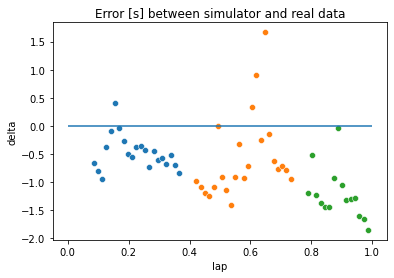

In [30]:
for dataset in datasets:
    tyre = dataset['tyre'].values[0]
    x = dataset[dataset['driver'] == driver].copy()
    x['delta'] = x['delta'] * max_time
    sns.scatterplot(x="lap", y="delta", data=x)
plt.title("Error [s] between simulator and real data")
plt.hlines(0, 0, 1)
plt.savefig("../figures/real_sim_error")

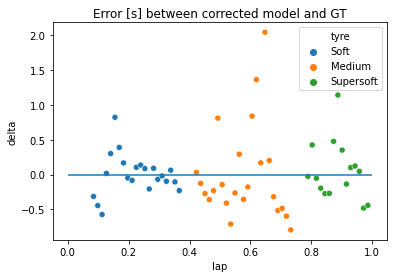

In [31]:
sns.scatterplot(x="lap", y="delta", data=error_df, hue="tyre")
plt.title("Error [s] between corrected model and GT")
plt.hlines(0, 0, 1)
plt.savefig("../figures/real_corrected_error")

Text(0.5, 1.0, 'Predicted correction [s]')

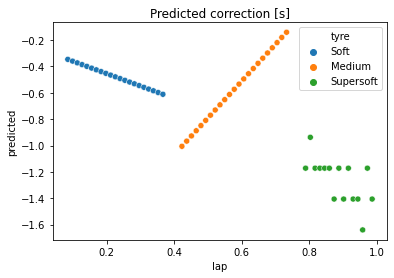

In [29]:
sns.scatterplot(x="lap", y="predicted", data=error_df, hue="tyre")
plt.title("Predicted correction [s]")
plt.savefig("../figures/correction")